In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/ML_SEG.zip' ML_SEG.zip
!unzip -qo ML_SEG.zip 
!rm ML_SEG.zip

In [3]:
!pip install -q segmentation-models-pytorch

     |████████████████████████████████| 87 kB 4.5 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 15.3 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time 
from tqdm.notebook import tqdm
from torchsummary import summary
import segmentation_models_pytorch as smp

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
images= "/content/ML_SEG/ARG_DATA/train/train/"
targets= "/content/ML_SEG/ARG_DATA/mask/mask/"

n_classes = 2

def _df_():
  name = []
  for dirname ,_ , filenames in os.walk(images):
    for filename in filenames:
      name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id':name} , index = np.arange(0, len(name)))

df = _df_()
print(len(df))

2000


In [6]:
X_train , X_val = train_test_split(df['id'].values , test_size
                                   =0.3 , random_state =19)
print(f'Train : {len(X_train)}')
print(f'Val : {len(X_val)}')

Train : 1400
Val : 600


Image Size (750, 750, 3)
Mask Size (750, 750)


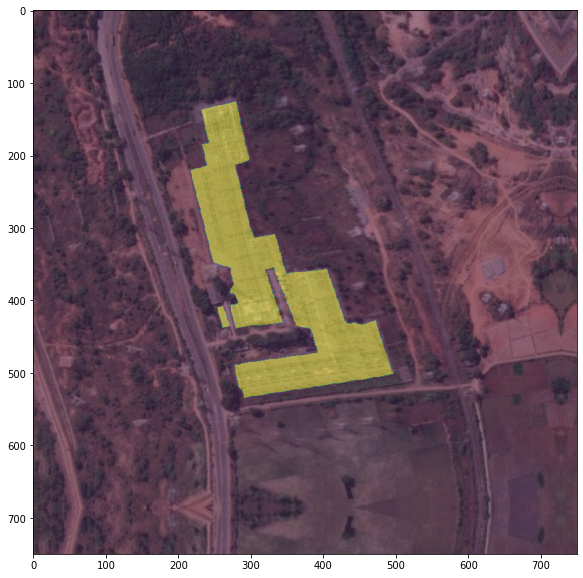

In [7]:
img = Image.open(images + df['id'][0] + '.png')
targ = Image.open(targets + df['id'][0] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size' , np.asarray(targ).shape)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(targ , alpha =0.4)
plt.show()

In [8]:
def dense_target(tar: np.ndarray):
    classes =np.unique(tar)
    dummy= np.zeros_like(tar)
    for idx , value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx
    return dummy

class SegData(Dataset):

  def __init__(self , image_path , target_path , X , mean , std , transform =None , test=False):
    self.image_path = image_path
    self.target_path = target_path
    self.X = X
    self.transform =transform
    self.mean = mean
    self.std = std
    self.test =test

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.image_path + self.X[idx] + '.png') , cv2.COLOR_BGR2RGB)
    target = cv2.imread(self.target_path + self.X[idx] + '.png' , cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512 , 512) , interpolation = cv2.INTER_NEAREST)
    target = cv2.resize(target , (512 , 512), interpolation = cv2.INTER_NEAREST)
    target = np.where( target > 0,255,0)
  
    if self.transform is not None:
      aug = self.transform(image = img , target = target )
      img = Image.fromarray(aug['image'])
      target = aug['target']
    
    if self.transform is None:
      img = Image.fromarray(img) 
    
    t = T.Compose([T.ToTensor() , T.Normalize(self.mean , self.std)])
    
    if self.test is False:
      img = t(img)
    target = dense_target(target)
    target = torch.from_numpy(target).long()
    return img ,target

In [9]:
mean = [0.485 ,0.456 ,0.406]
std = [0.229 , 0.224 , 0.225]

train_transforms = A.Compose([A.HorizontalFlip(), A.VerticalFlip(),
A.RandomBrightnessContrast((0,0.5), (0, 0.5))])

val_transforms = A.Compose([A.HorizontalFlip(), A.VerticalFlip(),
A.RandomBrightnessContrast((0,0.5), (0, 0.5))])

train_set = SegData(images, targets, X_train , mean, std , train_transforms)
val_set = SegData(images , targets , X_val , mean , std , val_transforms)

batch_size =4
train_loader= DataLoader(train_set , batch_size= batch_size , shuffle =True)
val_loader = DataLoader(val_set , batch_size = batch_size , shuffle =True)

In [10]:
x , y =next(iter(train_loader))

print(f' x = shape : {x.shape} ; type :{x.dtype}')
print(f' x = min : {x.min()} ; max : {x.max()}')
print(f' y = shape: {y.shape}; class : {y.unique()}; type: {y.dtype}')

 x = shape : torch.Size([4, 3, 512, 512]) ; type :torch.float32
 x = min : -2.1007792949676514 ; max : 2.640000104904175
 y = shape: torch.Size([4, 512, 512]); class : tensor([0, 1]); type: torch.int64


In [11]:
model = smp.Unet('resnet50', classes = 2, activation=None,
                 encoder_depth= 5, decoder_channels=[256,128, 64, 32,16])
model=model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [12]:
summary(model, input_size=(3, 512 , 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
def pixel_wise_accuracy(output , mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output , dim =1) , dim=1)
    correct = torch.eq(output , mask).int()
    accuracy = float(correct.sum())/ float(correct.numel())#total number
  return accuracy

In [14]:
def IoU(pred , true_pred , smooth =1e-10 , n_classes=2):
  with torch.no_grad():
    pred = torch.argmax(F.softmax(pred , dim =1) , dim=1)
    pred = pred.contiguous().view(-1)
    true_pred = true_pred.contiguous().view(-1)

    iou_class = []
    for value in range(0, n_classes):
      true_class = pred == value
      true_label = true_pred == value

      if true_label.long().sum().item()==0:
        iou_class.append(np.nan)
        
      else:
    
        inter = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class , true_label).sum().float().item()

        iou = (inter + smooth)/(union + smooth)
        iou_class.append(iou)

    return np.nanmean(iou_class)

In [15]:
def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = jaccard_loss(mask, output)
            #evaluation metrics
            iou_score += IoU(output, mask)
            accuracy += pixel_wise_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  IoU(output, mask)
                    test_accuracy += pixel_wise_accuracy(output, mask)
                    #loss
                    loss = jaccard_loss(mask, output)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'model-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            # if (test_loss/len(val_loader)) > min_loss:
            #     not_improve += 1
            #     min_loss = (test_loss/len(val_loader))
            #     print(f'Loss did not  Decrease for {not_improve} time')
            #     if not_improve == 7:
            #         print('Loss did not decrease for the 7th time , Stop Training')
            #         break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train IoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val IoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [17]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-6

optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, optimizer, sched)


Loss Decreasing.. inf >> 0.485 
Epoch:1/30.. Train Loss: 0.565.. Val Loss: 0.485.. Train IoU:0.571.. Val IoU: 0.625.. Train Acc:0.858.. Val Acc:0.906.. Time: 3.80m



Loss Decreasing.. 0.485 >> 0.462 
Epoch:2/30.. Train Loss: 0.476.. Val Loss: 0.462.. Train IoU:0.616.. Val IoU: 0.612.. Train Acc:0.914.. Val Acc:0.902.. Time: 3.88m



Loss Decreasing.. 0.462 >> 0.445 
Epoch:3/30.. Train Loss: 0.463.. Val Loss: 0.445.. Train IoU:0.609.. Val IoU: 0.636.. Train Acc:0.912.. Val Acc:0.920.. Time: 3.89m



Epoch:4/30.. Train Loss: 0.461.. Val Loss: 0.471.. Train IoU:0.608.. Val IoU: 0.582.. Train Acc:0.914.. Val Acc:0.907.. Time: 3.86m



Epoch:5/30.. Train Loss: 0.473.. Val Loss: 0.485.. Train IoU:0.585.. Val IoU: 0.564.. Train Acc:0.907.. Val Acc:0.913.. Time: 3.83m



Epoch:6/30.. Train Loss: 0.474.. Val Loss: 0.485.. Train IoU:0.583.. Val IoU: 0.562.. Train Acc:0.904.. Val Acc:0.878.. Time: 3.82m



Epoch:7/30.. Train Loss: 0.461.. Val Loss: 0.470.. Train IoU:0.606.. Val IoU: 0.591.. Train Acc:0.913.. Val Acc:0.906.. Time: 3.78m



Epoch:8/30.. Train Loss: 0.460.. Val Loss: 0.464.. Train IoU:0.606.. Val IoU: 0.596.. Train Acc:0.913.. Val Acc:0.898.. Time: 3.78m



Epoch:9/30.. Train Loss: 0.469.. Val Loss: 0.452.. Train IoU:0.595.. Val IoU: 0.613.. Train Acc:0.909.. Val Acc:0.910.. Time: 3.77m



Epoch:10/30.. Train Loss: 0.458.. Val Loss: 0.455.. Train IoU:0.611.. Val IoU: 0.607.. Train Acc:0.913.. Val Acc:0.906.. Time: 3.78m



Epoch:11/30.. Train Loss: 0.455.. Val Loss: 0.453.. Train IoU:0.614.. Val IoU: 0.619.. Train Acc:0.916.. Val Acc:0.908.. Time: 3.78m



Epoch:12/30.. Train Loss: 0.457.. Val Loss: 0.456.. Train IoU:0.611.. Val IoU: 0.613.. Train Acc:0.914.. Val Acc:0.903.. Time: 3.78m



Epoch:13/30.. Train Loss: 0.450.. Val Loss: 0.458.. Train IoU:0.622.. Val IoU: 0.609.. Train Acc:0.918.. Val Acc:0.901.. Time: 3.78m



Epoch:14/30.. Train Loss: 0.456.. Val Loss: 0.467.. Train IoU:0.613.. Val IoU: 0.597.. Train Acc:0.914.. Val Acc:0.906.. Time: 3.78m



Epoch:15/30.. Train Loss: 0.461.. Val Loss: 0.456.. Train IoU:0.605.. Val IoU: 0.607.. Train Acc:0.911.. Val Acc:0.903.. Time: 3.80m



Epoch:16/30.. Train Loss: 0.452.. Val Loss: 0.447.. Train IoU:0.619.. Val IoU: 0.622.. Train Acc:0.917.. Val Acc:0.916.. Time: 3.80m



Loss Decreasing.. 0.445 >> 0.441 
saving model...
Epoch:17/30.. Train Loss: 0.450.. Val Loss: 0.441.. Train IoU:0.623.. Val IoU: 0.639.. Train Acc:0.918.. Val Acc:0.923.. Time: 3.81m



Epoch:18/30.. Train Loss: 0.453.. Val Loss: 0.462.. Train IoU:0.620.. Val IoU: 0.597.. Train Acc:0.917.. Val Acc:0.899.. Time: 3.82m



Loss Decreasing.. 0.441 >> 0.436 
Epoch:19/30.. Train Loss: 0.451.. Val Loss: 0.436.. Train IoU:0.619.. Val IoU: 0.640.. Train Acc:0.918.. Val Acc:0.920.. Time: 3.82m



Epoch:20/30.. Train Loss: 0.446.. Val Loss: 0.444.. Train IoU:0.629.. Val IoU: 0.625.. Train Acc:0.921.. Val Acc:0.915.. Time: 3.82m



Loss Decreasing.. 0.436 >> 0.429 
Epoch:21/30.. Train Loss: 0.444.. Val Loss: 0.429.. Train IoU:0.633.. Val IoU: 0.649.. Train Acc:0.923.. Val Acc:0.919.. Time: 3.81m



Loss Decreasing.. 0.429 >> 0.426 
Epoch:22/30.. Train Loss: 0.443.. Val Loss: 0.426.. Train IoU:0.634.. Val IoU: 0.653.. Train Acc:0.923.. Val Acc:0.922.. Time: 3.80m



Loss Decreasing.. 0.426 >> 0.425 
Epoch:23/30.. Train Loss: 0.439.. Val Loss: 0.425.. Train IoU:0.644.. Val IoU: 0.657.. Train Acc:0.926.. Val Acc:0.924.. Time: 3.80m



Epoch:24/30.. Train Loss: 0.438.. Val Loss: 0.438.. Train IoU:0.642.. Val IoU: 0.640.. Train Acc:0.925.. Val Acc:0.918.. Time: 3.77m



Epoch:25/30.. Train Loss: 0.433.. Val Loss: 0.437.. Train IoU:0.650.. Val IoU: 0.641.. Train Acc:0.928.. Val Acc:0.918.. Time: 3.77m



Epoch:26/30.. Train Loss: 0.434.. Val Loss: 0.427.. Train IoU:0.647.. Val IoU: 0.659.. Train Acc:0.927.. Val Acc:0.927.. Time: 3.77m



Epoch:27/30.. Train Loss: 0.431.. Val Loss: 0.428.. Train IoU:0.653.. Val IoU: 0.655.. Train Acc:0.929.. Val Acc:0.924.. Time: 3.77m



Epoch:28/30.. Train Loss: 0.437.. Val Loss: 0.431.. Train IoU:0.650.. Val IoU: 0.653.. Train Acc:0.927.. Val Acc:0.923.. Time: 3.78m



Epoch:29/30.. Train Loss: 0.426.. Val Loss: 0.443.. Train IoU:0.661.. Val IoU: 0.637.. Train Acc:0.931.. Val Acc:0.915.. Time: 3.79m



Epoch:30/30.. Train Loss: 0.430.. Val Loss: 0.426.. Train IoU:0.656.. Val IoU: 0.661.. Train Acc:0.929.. Val Acc:0.924.. Time: 3.80m
Total time: 114.02 m


In [21]:
test_set = SegData(images, targets, X_val ,mean , std, transform = None , test = True)

In [22]:
def predict_image_mask(model, image , mask , mean=[0.485, 0.456, 0.406],
                       std = [0.229 , 0.224 ,0.225]):
  model.eval()
  t= T.Compose([T.ToTensor() ,T.Normalize(mean, std)])
  image = t(image)
  model.to(device) ; image = image.to(device)
  mask = mask.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    output = model(image)
    score = IoU(output, mask)
    masked = torch.argmax(output , dim =1)
    masked = masked.cpu().squeeze(0)
  return masked , score

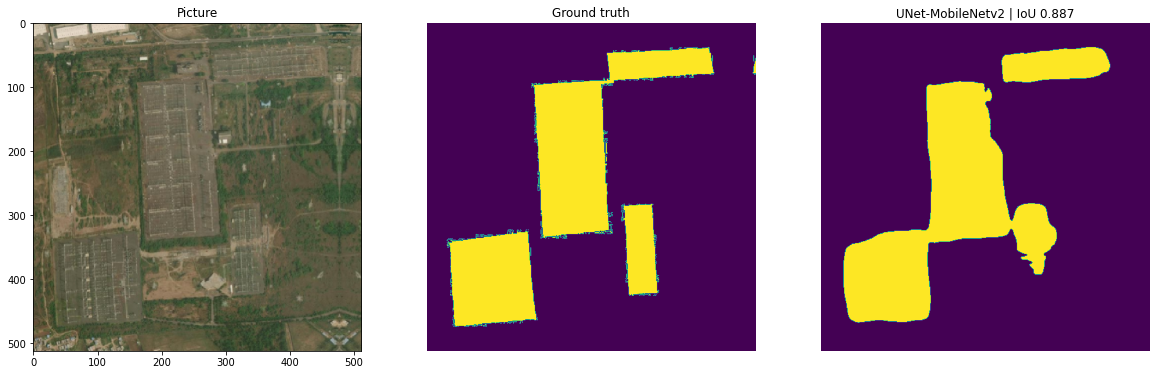

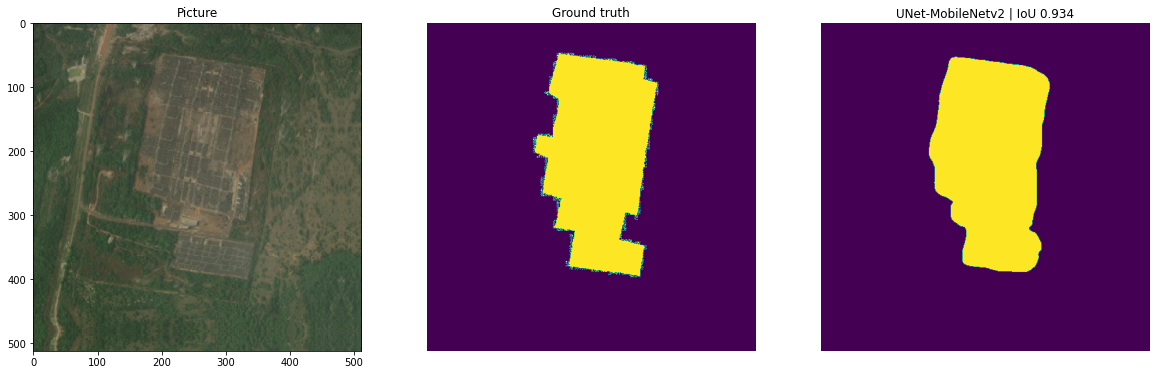

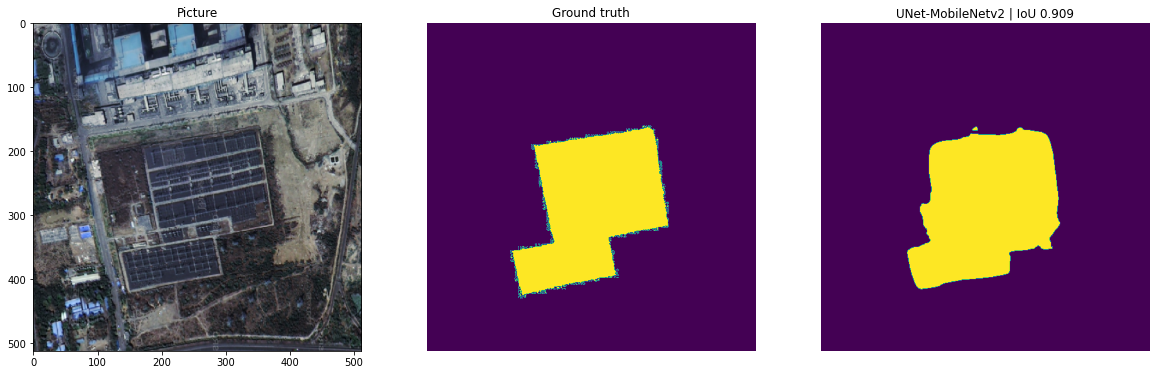

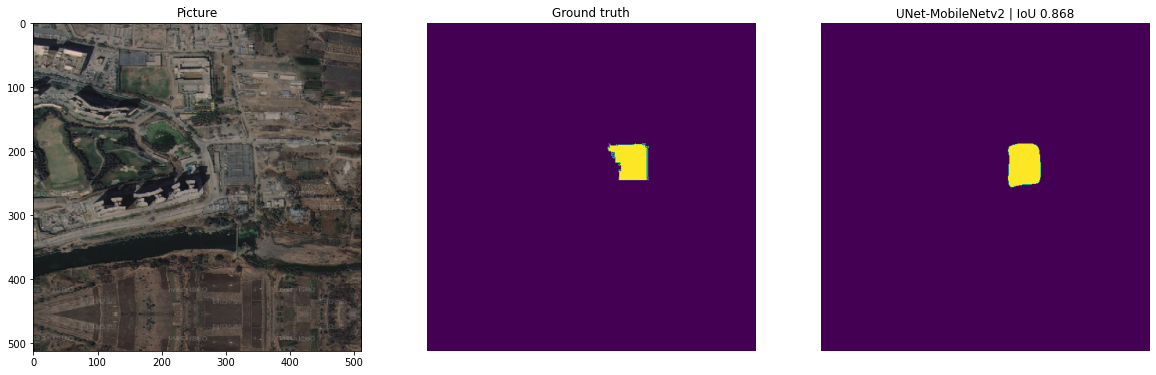

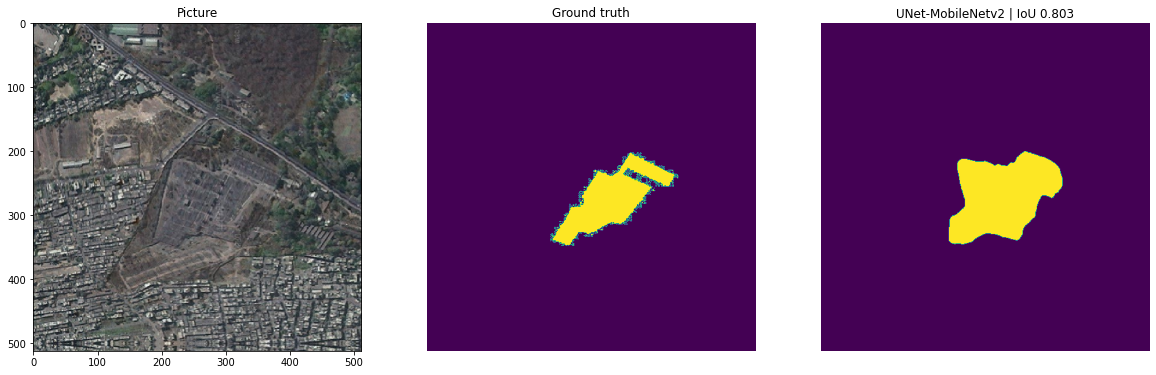

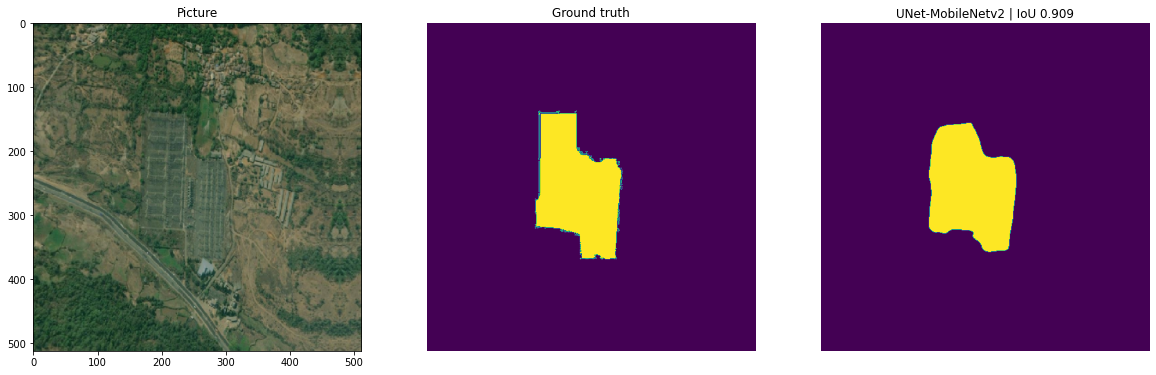

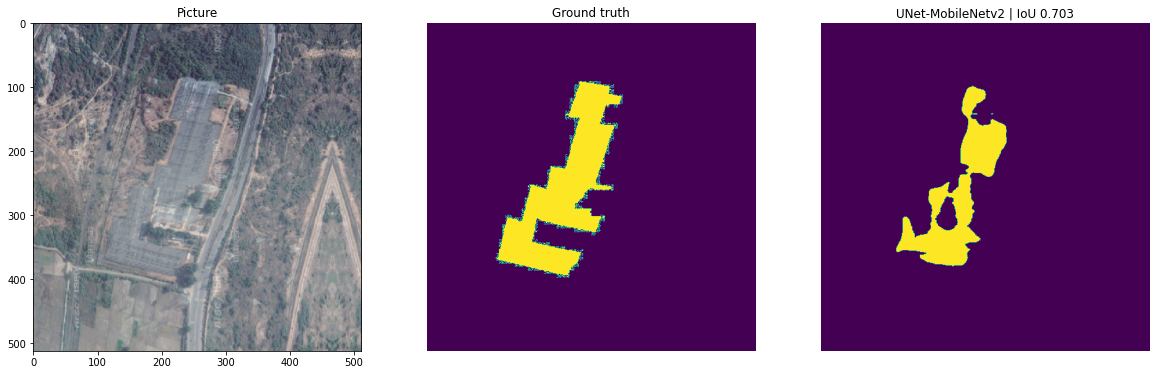

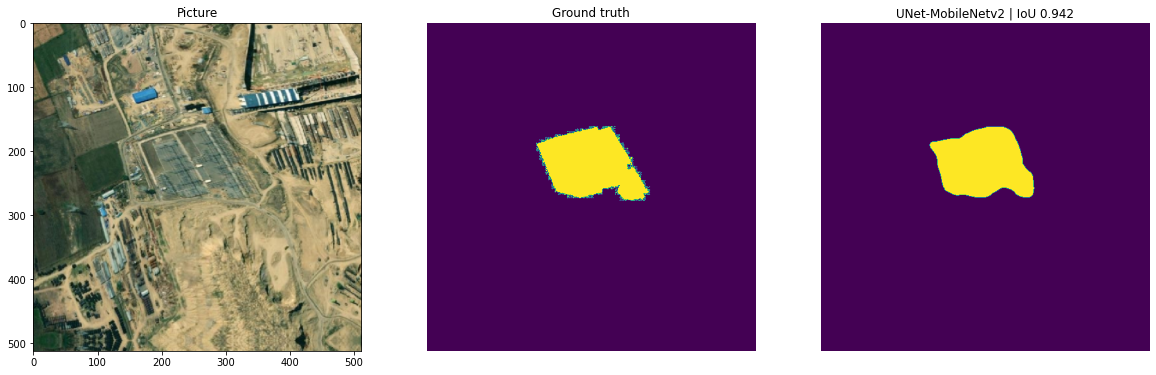

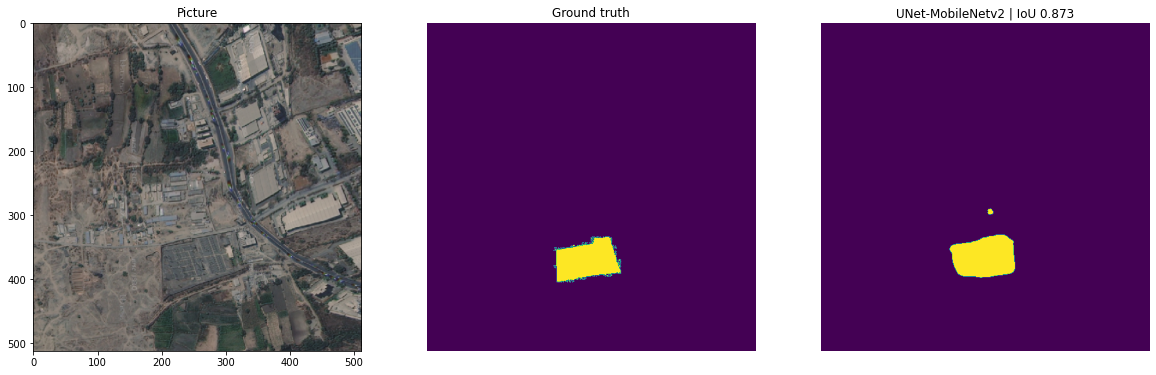

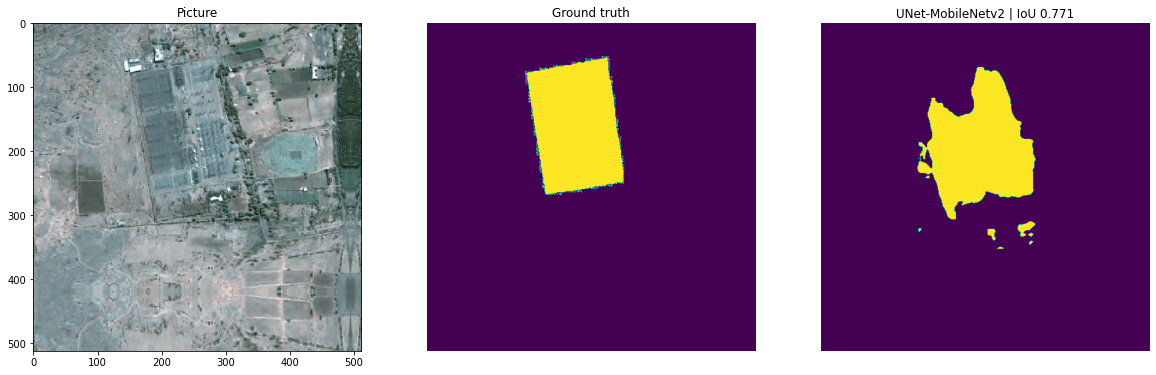

In [23]:
import random
for i in range(10):
  image , mask = test_set[i]
  pred_mask , score = predict_image_mask(model , image , mask)
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-MobileNetv2 | IoU {:.3f}'.format(score))
  ax3.set_axis_off()